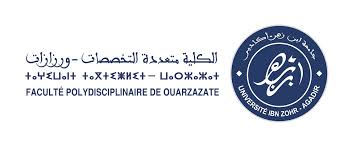

**Réaliser Par:**<br>
YOUSSEF EL WALI<br>
**Encadrer Par:**<br>
Abdelkrim EL MOUATASIM

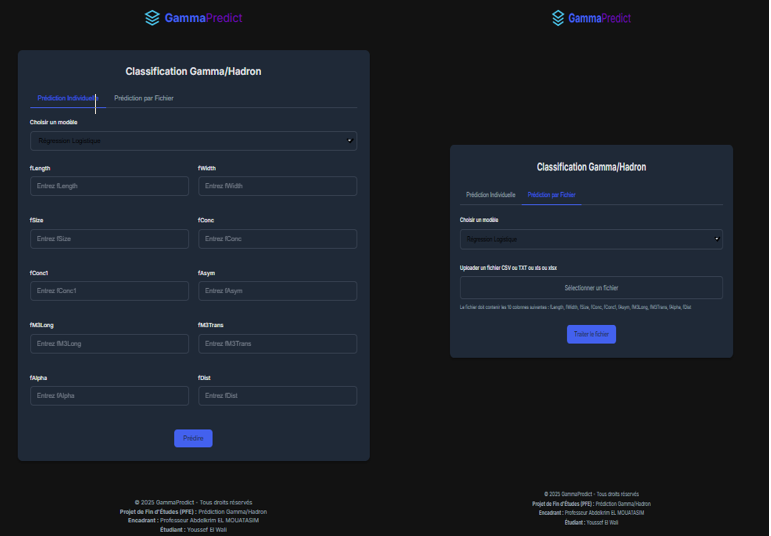

# <span style="color: red;">Deep Learning for Gamma Telescope </span>

<h2 style="color:red">1-chargé les bibliothéques nécessaires</h2>

![](http://)

In [ ]:
pip uninstall scikit-learn -y

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install --upgrade pip setuptools

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install scikit-learn

  Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (17 kB)
Using cached scikit_learn-1.7.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install --upgrade scikit-learn imbalanced-learn

  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV

In [ ]:
df=pd.read_csv('/kaggle/input/telescope-datas/telescope_data.csv')
df.columns

Index(['Unnamed: 0', 'fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym',
       'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class'],
      dtype='object')

<h2> convertir des valeurs catégorielles (lettres) en valeurs numériques dans une colonne d’un DataFrame

In [ ]:
df['class']=df['class'].map({'g':0,'h':1})

In [ ]:
X = df.drop('class',axis=1)
X = X.drop('Unnamed: 0',axis=1)
y=df['class']

 <h2>transformer les variables numériques pour qu'elles aient une distribution plus normale (gaussienne).

In [ ]:
# Sélectionner uniquement les colonnes numériques
numerical_cols = X.select_dtypes(include=['number']).columns
# Initialiser le PowerTransformer avec Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
# Appliquer la transformation
X[numerical_cols] = pt.fit_transform(X[numerical_cols])

<h2>normaliser les colonnes numériques de X en utilisant une méthode robuste aux valeurs extrêmes (outliers)

In [ ]:
scaler = RobustScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

<h2>Ce code sert à équilibrer les classes dans un jeu de données de classification binaire ou multi-classe lorsqu’il y a un déséquilibre (class imbalance) entre les étiquettes.

In [ ]:
smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X,y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

**Ce code vérifie la disponibilité d'un GPU compatible CUDA et définit le périphérique de calcul sur le GPU s'il est disponible, sinon il utilise le CPU.**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Ce code définit une **réseau de neurones** en PyTorch avec deux couches cachées et fournit des méthodes pour **calculer la précision** et **entraîner le modèle** sur une époque.

In [ ]:
#build a neural network
class Net(nn.Module):
    def __init__(self, hiddenSize1, hiddenSize2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, hiddenSize1)
        self.fc2 = nn.Linear(hiddenSize1, hiddenSize2)
        self.fc3 = nn.Linear(hiddenSize2, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def getAccuracy(self, dataset):
        with torch.no_grad():
            correct = 0
            total = 0
            for x, y in dataset:
                x, y = x.to(device), y.to(device)
                output = self(x.float())
                for idx, i in enumerate(output):
                    if torch.argmax(i) == y[idx]:
                        correct += 1
                    total += 1
            return correct / total

    def trainOneEpoch(self, trainDataset, optimizer, criterion):  # Ajout de `self`
        self.train()  # Active le mode entraînement
        for data in trainDataset:
            inputs, labels = data
            inputs, labels = inputs.to(device).float(), labels.to(device)

            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


# Ce code prépare les données d'entraînement et de test pour un modèle PyTorch en les transformant en DataLoader et en tenseurs PyTorch

In [ ]:
train = []
test = []
, X_test, y_train, y_test
for i in range(len(X_train)):
    train.append([X_train.iloc[i].values,y_train.iloc[i]])

for i in range(len(X_test)):
    test.append([X_test.iloc[i].values,y_test.iloc[i]])

trainDataSet = torch.utils.data.DataLoader(train, batch_size=512)
testDataSet = torch.utils.data.DataLoader(test, batch_size=512)
x_train_torch = torch.tensor(X_train.values,device=device)
y_train_torch = torch.tensor(y_train.values,device=device)
x_test_torch = torch.tensor(X_test.values,device=device)
y_test_torch = torch.tensor(y_test.values,device=device)

# Ce code effectue une validation croisée avec K-Fold sur un réseau de neurones PyTorch en testant différentes tailles de couches cachées.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

# Vérifie si GPU est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Définition de la fonction de perte
criterion = nn.CrossEntropyLoss().to(device)

# Paramètres de la validation croisée
kfold = KFold(n_splits=10)
averageValidationAccuracy = []

# Définition des tailles de couches cachées
hiddenLayer1 = [70, 90,95]
hiddenLayer2 = [70, 90,95]

for i, n1 in enumerate(hiddenLayer1):
    averageValidationAccuracy.append([])
    for j, n2 in enumerate(hiddenLayer2):
        kfoldAccuracy = 0

        for train_index, test_index in kfold.split(X_train, y_train):
            x_train_fold = x_train_torch[train_index].to(device)
            y_train_fold = y_train_torch[train_index].to(device)
            x_test_fold = x_train_torch[test_index].to(device)
            y_test_fold = y_train_torch[test_index].to(device)

            train_dataset = TensorDataset(x_train_fold, y_train_fold)
            test_dataset = TensorDataset(x_test_fold, y_test_fold)
            train_loader = DataLoader(train_dataset, batch_size=512)
            test_loader = DataLoader(test_dataset, batch_size=512)

            model = Net(n1, n2).to(device)
            optimizer = optim.Adam(model.parameters(), lr=0.01)

            for epoch in range(100):
                model.trainOneEpoch(train_loader, optimizer, criterion)

            kfoldAccuracy += model.getAccuracy(test_loader)

        kfoldAccuracy /= 10
        averageValidationAccuracy[i].append(kfoldAccuracy)

        print(f"n1 = {n1}, n2 = {n2}")
        print(f"Validation Accuracy: {averageValidationAccuracy[i][j]:.4f}")

Using device: cuda
n1 = 70, n2 = 70
Validation Accuracy: 0.8658
n1 = 70, n2 = 90
Validation Accuracy: 0.8605
n1 = 70, n2 = 95
Validation Accuracy: 0.8675
n1 = 90, n2 = 70
Validation Accuracy: 0.8681
n1 = 90, n2 = 90
Validation Accuracy: 0.8637
n1 = 90, n2 = 95
Validation Accuracy: 0.8618
n1 = 95, n2 = 70
Validation Accuracy: 0.8670
n1 = 95, n2 = 90
Validation Accuracy: 0.8655
n1 = 95, n2 = 95
Validation Accuracy: 0.8697


# trouver la meilleure combinaison de tailles de couches cachées (hiddenLayer1, hiddenLayer2) en évacuant l'overfitting et en enregistrant le meilleur modèle.

In [ ]:
bestAccuracy = 0
bestHiddenLayer1 = 0
bestHiddenLayer2 = 0
scores = []

for i, n1 in enumerate(hiddenLayer1):
    for j, n2 in enumerate(hiddenLayer2):
        model = Net(n1, n2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        accuracyBeforeOverfitting = 0

        # Préparer le DataLoader d'entraînement complet
        train_dataset = TensorDataset(x_train_torch.to(device), y_train_torch.to(device))
        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

        for epoch in range(100):
            model.trainOneEpoch(train_loader, optimizer, criterion)

            modelAccuracy = model.getAccuracy(train_loader)

            # Détection de surapprentissage (gap > 5% entre entraînement et validation)
            if modelAccuracy - averageValidationAccuracy[i][j] > 0.05:
                break

            accuracyBeforeOverfitting = modelAccuracy

            # Sauvegarde du meilleur modèle
            if modelAccuracy > bestAccuracy:
                bestAccuracy = modelAccuracy
                torch.save(model.state_dict(), "model.pt")  # Bonne pratique : sauvegarder le state_dict
                bestHiddenLayer1 = n1
                bestHiddenLayer2 = n2

        scores.append(accuracyBeforeOverfitting)

# Obtenir les prédictions du modèle et les étiquettes réelles pour une évaluation des performances.

In [ ]:
y_pred = []
y_actual = []

# Step 1: Recreate your model architecture with the CORRECT parameters
# D'après l'erreur, votre modèle utilise hiddenSize1=70 et hiddenSize2=70
bestModel = Net(hiddenSize1=95, hiddenSize2=95)

# Step 2: Load the state dictionary
state_dict = torch.load("model.pt", weights_only=False)

# Step 3: Load the weights into the model
bestModel.load_state_dict(state_dict)

# Step 4: Set model to evaluation mode and move to CPU
bestModel.eval()
bestModel.to("cpu")

with torch.no_grad():
    for input, labels in testDataSet:
        outputs = bestModel(input.float())
        # Get the predicted class
        for i in outputs:
            y_pred.append(torch.argmax(i))
        # Get the actual class
        for i in labels:
            y_actual.append(i)

In [ ]:
print(bestHiddenLayer1,bestHiddenLayer2)

95 95


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
accuracy_to = accuracy_score(y_actual,y_pred)
precision_to = precision_score(y_actual,y_pred, average='weighted')  # Moyenne pondérée pour plusieurs classes
recall_to = recall_score(y_actual,y_pred, average='weighted')
f1_to = f1_score(y_actual, y_pred, average='weighted')

In [ ]:
print(f"Précision globale (Accuracy) : {accuracy_to:.4f}")
print(f"Précision pondérée (Precision) : {precision_to:.4f}")
print(f"Rappel pondéré (Recall) : {recall_to:.4f}")
print(f"F1-score: {f1_to:.4f}")

Précision globale (Accuracy) : 0.8692
Précision pondérée (Precision) : 0.8698
Rappel pondéré (Recall) : 0.8692
F1-score: 0.8692


# Ce code génère un rapport de classification pour évaluer la performance du modèle sur les données de test.

In [ ]:
print(classification_report(y_actual,y_pred, target_names=['g','h']))

              precision    recall  f1-score   support

           g       0.86      0.89      0.87      2498
           h       0.88      0.85      0.86      2435

    accuracy                           0.87      4933
   macro avg       0.87      0.87      0.87      4933
weighted avg       0.87      0.87      0.87      4933



# Visualiser la matrice de confusion pour observer la distribution des prédictions du modèle par rapport aux vraies étiquettes.

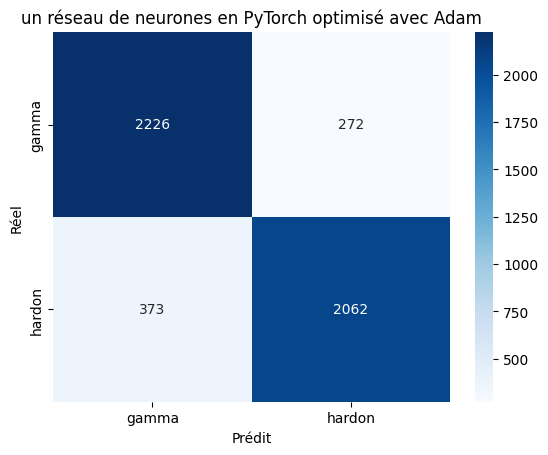

In [ ]:
cm = confusion_matrix(y_actual,y_pred)
# Afficher la matrice de confusion sous forme de heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["gamma", "hardon"], yticklabels=["gamma", "hardon"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("un réseau de neurones en PyTorch optimisé avec Adam")
plt.show()

<h2>Ce code a pour intérêt principal de tracer la courbe ROC et calculer l’AUC (aire sous la courbe) pour évaluer les performances d’un modèle de classification binaire ou multiclasse construit avec PyTorch.

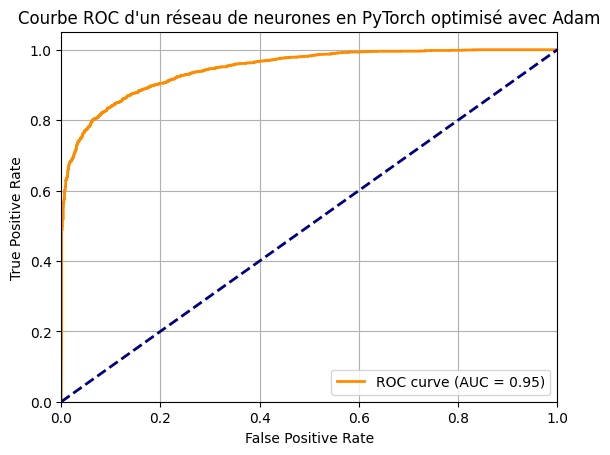

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
# S'assurer que y_test est bien en format tensor sur CPU
y_true = []
y_score = []

bestModel.eval()
bestModel.to("cpu")

with torch.no_grad():
    for inputs, labels in testDataSet:
        outputs = bestModel(inputs.float())
        probs = torch.softmax(outputs, dim=1)  # Probabilités
        y_score.extend(probs.numpy())          # Liste de vecteurs de probabilités
        y_true.extend(labels.numpy())          # Classes réelles

y_true = np.array(y_true)
y_score = np.array(y_score)

# Si binaire, traiter directement
if y_score.shape[1] == 2:
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])  # colonnes = proba pour la classe 1
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Courbe ROC d'un réseau de neurones en PyTorch optimisé avec Adam")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Si multiclasse, tracer une ROC pour chaque classe
else:
    n_classes = y_score.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

<h2>Ce code a pour intérêt principal de rechercher la meilleure architecture pour un réseau de neurones artificiels (MLP)

In [ ]:
bestAccuracy = 0
bestHiddenLayer1 = 0
bestHiddenLayer2 = 0
scores = []

for i, n1 in enumerate(hiddenLayer1):
    for j, n2 in enumerate(hiddenLayer2):
        model = Net(n1, n2).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        accuracyBeforeOverfitting = 0

        # Préparer le DataLoader d'entraînement complet
        train_dataset = TensorDataset(x_train_torch.to(device), y_train_torch.to(device))
        train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

        for epoch in range(100):
            model.trainOneEpoch(train_loader, optimizer, criterion)

            modelAccuracy = model.getAccuracy(train_loader)

            # Détection de surapprentissage (gap > 5% entre entraînement et validation)
            if modelAccuracy - averageValidationAccuracy[i][j] > 0.05:
                break

            accuracyBeforeOverfitting = modelAccuracy

            # Sauvegarde du meilleur modèle
            if modelAccuracy > bestAccuracy:
                bestAccuracy = modelAccuracy
                torch.save(model.state_dict(), "model.pt")  # Bonne pratique : sauvegarder le state_dict
                bestHiddenLayer1 = n1
                bestHiddenLayer2 = n2

        scores.append(accuracyBeforeOverfitting)

<h2>Charger un modèle PyTorch pré-entraîné sauvegardé, faire des prédictions sur un jeu de test, et récupérer les classes prédites ainsi que les classes réelles pour évaluer le modèle.



In [ ]:
y_pred = []
y_actual = []

# Step 1: Recreate your model architecture with the CORRECT parameters
# D'après l'erreur, votre modèle utilise hiddenSize1=70 et hiddenSize2=70
bestModel = Net(hiddenSize1=95, hiddenSize2=90)

# Step 2: Load the state dictionary
state_dict = torch.load("model.pt", weights_only=False)

# Step 3: Load the weights into the model
bestModel.load_state_dict(state_dict)

# Step 4: Set model to evaluation mode and move to CPU
bestModel.eval()
bestModel.to("cpu")

with torch.no_grad():
    for input, labels in testDataSet:
        outputs = bestModel(input.float())
        # Get the predicted class
        for i in outputs:
            y_pred.append(torch.argmax(i))
        # Get the actual class
        for i in labels:
            y_actual.append(i)

In [ ]:
print(bestHiddenLayer1,bestHiddenLayer2)

95 90


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
accuracy_SD = accuracy_score(y_actual,y_pred)
precision_SD = precision_score(y_actual,y_pred, average='weighted')  # Moyenne pondérée pour plusieurs classes
recall_SD = recall_score(y_actual,y_pred, average='weighted')
f1_SD = f1_score(y_actual, y_pred, average='weighted')

In [ ]:
print(f"Précision globale (Accuracy) : {accuracy_SD:.4f}")
print(f"Précision pondérée (Precision) : {precision_SD:.4f}")
print(f"Rappel pondéré (Recall) : {recall_SD:.4f}")
print(f"F1-score: {f1_SD:.4f}")

Précision globale (Accuracy) : 0.8672
Précision pondérée (Precision) : 0.8690
Rappel pondéré (Recall) : 0.8672
F1-score: 0.8670


In [ ]:
print(classification_report(y_actual,y_pred, target_names=['g','h']))

              precision    recall  f1-score   support

           g       0.84      0.90      0.87      2498
           h       0.89      0.83      0.86      2435

    accuracy                           0.87      4933
   macro avg       0.87      0.87      0.87      4933
weighted avg       0.87      0.87      0.87      4933



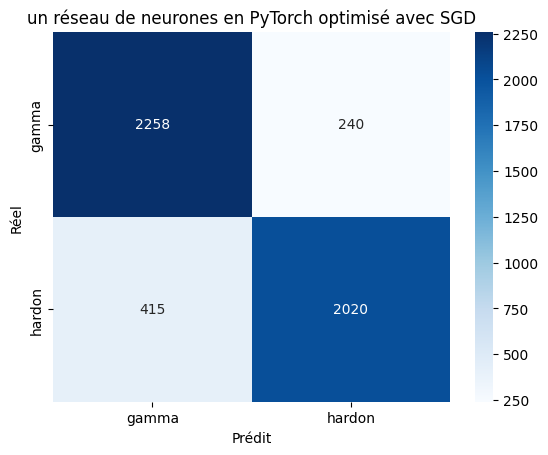

In [ ]:
cm = confusion_matrix(y_actual,y_pred)
# Afficher la matrice de confusion sous forme de heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["gamma", "hardon"], yticklabels=["gamma", "hardon"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("un réseau de neurones en PyTorch optimisé avec SGD")
plt.show()

<h2>Ce code a pour intérêt principal de tracer la courbe ROC et calculer l’AUC (aire sous la courbe) pour évaluer les performances d’un modèle de classification binaire ou multiclasse construit avec PyTorch.

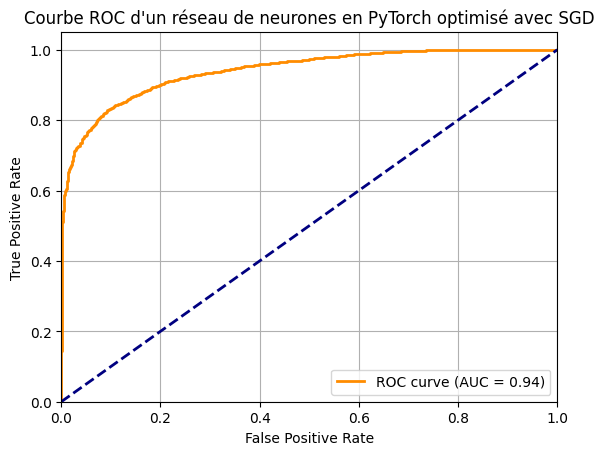

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
# S'assurer que y_test est bien en format tensor sur CPU
y_true = []
y_score = []

bestModel.eval()
bestModel.to("cpu")

with torch.no_grad():
    for inputs, labels in testDataSet:
        outputs = bestModel(inputs.float())
        probs = torch.softmax(outputs, dim=1)  # Probabilités
        y_score.extend(probs.numpy())          # Liste de vecteurs de probabilités
        y_true.extend(labels.numpy())          # Classes réelles

y_true = np.array(y_true)
y_score = np.array(y_score)

# Si binaire, traiter directement
if y_score.shape[1] == 2:
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])  # colonnes = proba pour la classe 1
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Courbe ROC d'un réseau de neurones en PyTorch optimisé avec SGD")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Si multiclasse, tracer une ROC pour chaque classe
else:
    n_classes = y_score.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    plt.figure()
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

<h2>Construire un modèle de réseau de neurones avec PyTorch, puis utiliser RandomizedSearchCV de scikit-learn pour faire une recherche aléatoire d’hyperparamètres (taille des couches cachées, taux d’apprentissage, nombre d’époques), afin de trouver la meilleure configuration pour classifier les données.

In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example data (replace with your actual data)
# X_resampled and y_resampled should be your preprocessed datasets
# X_resampled = pd.DataFrame(np.random.rand(1000, 10))  # Example: 1000 samples, 10 features
# y_resampled = pd.Series(np.random.randint(0, 2, 1000))  # Example: Binary classification

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
x_train_torch = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train.values, dtype=torch.long).to(device)
x_test_torch = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Create DataLoader
train_dataset = TensorDataset(x_train_torch, y_train_torch)
test_dataset = TensorDataset(x_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size, hiddenSize1, hiddenSize2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hiddenSize1)
        self.fc2 = nn.Linear(hiddenSize1, hiddenSize2)
        self.fc3 = nn.Linear(hiddenSize2, 2)  # 2 output classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def getAccuracy(self, dataloader):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

# Define a wrapper class for RandomizedSearchCV
class TorchModel(BaseEstimator, ClassifierMixin):
    def __init__(self, hiddenSize1=50, hiddenSize2=50, lr=0.01, epochs=10):
        self.hiddenSize1 = hiddenSize1
        self.hiddenSize2 = hiddenSize2
        self.lr = lr
        self.epochs = epochs
        self.model = None

    def fit(self, X, y):
        X_torch = torch.tensor(X.values, dtype=torch.float32).to(device)
        y_torch = torch.tensor(y.values, dtype=torch.long).to(device)
        dataset = TensorDataset(X_torch, y_torch)
        dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

        input_size = X.shape[1]
        self.model = Net(input_size, self.hiddenSize1, self.hiddenSize2).to(device)
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        X_torch = torch.tensor(X.values, dtype=torch.float32).to(device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(X_torch)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu().numpy()

    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y.values)

# Define hyperparameter space for RandomizedSearchCV
param_dist = {
    'hiddenSize1': sp_randint(10, 100),
    'hiddenSize2': sp_randint(10, 100),
    'lr': [0.001, 0.01, 0.1],
    'epochs': [10, 20, 50]
}

# Perform RandomizedSearchCV
torch_model = TorchModel()
random_search = RandomizedSearchCV(
    torch_model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best hyperparameters found: ", random_search.best_params_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the best model
torch.save(best_model.model.state_dict(), "best_model.pth")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ..epochs=10, hiddenSize1=30, hiddenSize2=92, lr=0.1; total time=   3.8s
[CV] END ..epochs=10, hiddenSize1=30, hiddenSize2=92, lr=0.1; total time=   2.0s
[CV] END ..epochs=10, hiddenSize1=30, hiddenSize2=92, lr=0.1; total time=   2.1s
[CV] END ..epochs=50, hiddenSize1=61, hiddenSize2=24, lr=0.1; total time=  12.1s
[CV] END ..epochs=50, hiddenSize1=61, hiddenSize2=24, lr=0.1; total time=  12.1s
[CV] END ..epochs=50, hiddenSize1=61, hiddenSize2=24, lr=0.1; total time=  12.1s
[CV] END epochs=50, hiddenSize1=84, hiddenSize2=97, lr=0.001; total time=  10.5s
[CV] END epochs=50, hiddenSize1=84, hiddenSize2=97, lr=0.001; total time=  10.5s
[CV] END epochs=50, hiddenSize1=84, hiddenSize2=97, lr=0.001; total time=  10.5s
[CV] END .epochs=50, hiddenSize1=31, hiddenSize2=62, lr=0.01; total time=  10.5s
[CV] END epochs=20, hiddenSize1=47, hiddenSize2=11, lr=0.001; total time=   4.3s
[CV] END epochs=20, hiddenSize1=47, hiddenSize2=

In [ ]:
# Obtenir les prédictions du meilleur modèle
y_pred = best_model.predict(X_test)

# Générer le rapport de classification
report = classification_report(y_test, y_pred, target_names=["gamma", "hardon"])  # Remplacez par les noms de vos classes

# Afficher le rapport
print("Rapport de Classification RandomizedSearchCV :")
print(report)

# Sauvegarder le rapport dans un fichier (optionnel)
with open("rapport_classification.txt", "w") as f:
    f.write(report)

Rapport de Classification RandomizedSearchCV :
              precision    recall  f1-score   support

       gamma       0.84      0.92      0.88      2498
      hardon       0.90      0.82      0.86      2435

    accuracy                           0.87      4933
   macro avg       0.87      0.87      0.87      4933
weighted avg       0.87      0.87      0.87      4933



In [ ]:
accuracy_Ra = accuracy_score(y_test, y_pred)
precision_Ra = precision_score(y_test, y_pred, average='weighted')  # Moyenne pondérée pour plusieurs classes
recall_Ra = recall_score(y_test, y_pred, average='weighted')
f1_Ra = f1_score(y_test, y_pred, average='weighted')

In [ ]:
print(f"Précision globale (Accuracy) : {accuracy_Ra:.4f}")
print(f"Précision pondérée (Precision) : {precision_Ra:.4f}")
print(f"Rappel pondéré (Recall) : {recall_Ra:.4f}")
print(f"F1-score: {f1_Ra:.4f}")

Précision globale (Accuracy) : 0.8707
Précision pondérée (Precision) : 0.8734
Rappel pondéré (Recall) : 0.8707
F1-score: 0.8703


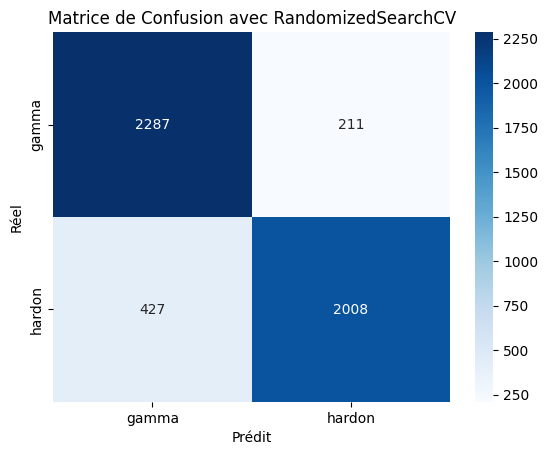

In [ ]:
# Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# Afficher la matrice de confusion sous forme de heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["gamma", "hardon"], yticklabels=["gamma", "hardon"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de Confusion avec RandomizedSearchCV")
plt.show()

Tableau ROC :
   Seuil  Taux Faux Positifs (FPR)  Taux Vrais Positifs (TPR)
0    inf                  0.000000                   0.000000
1    1.0                  0.084468                   0.824641
2    0.0                  1.000000                   1.000000


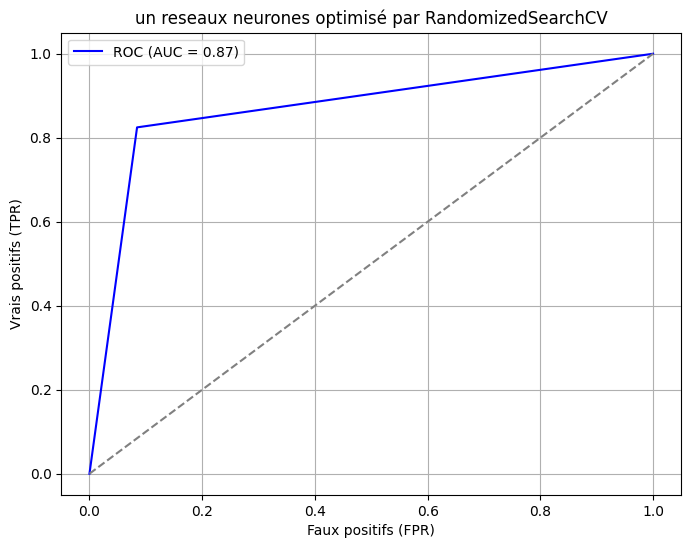

In [ ]:
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Obtenir les probabilités prédites pour la classe positive
y_scores = best_model.predict(X_test)

# Générer les points pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Créer le tableau ROC
roc_df = pd.DataFrame({
    'Seuil': thresholds,
    'Taux Faux Positifs (FPR)': fpr,
    'Taux Vrais Positifs (TPR)': tpr
})

print("Tableau ROC :")
print(roc_df.head(10))  # Affiche les 10 premières lignes

# Optionnel : tracer la courbe ROC
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Faux positifs (FPR)")
plt.ylabel("Vrais positifs (TPR)")
plt.title("un reseaux neurones optimisé par RandomizedSearchCV")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Définir la grille d'hyperparamètres
param_grid = {
    'hiddenSize1': [10, 30, 50, 70, 90],  # Liste des valeurs à tester
    'hiddenSize2': [10, 30, 50, 70, 90],  # Liste des valeurs à tester
    'lr': [0.001, 0.01, 0.1],             # Liste des taux d'apprentissage
    'epochs': [10, 20, 50]                # Liste des nombres d'époques
}

# Créer un modèle TorchModel
torch_model = TorchModel()

# Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(
    torch_model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1
)

# Adapter GridSearchCV aux données
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés : ", grid_search.best_params_)

# Évaluer le meilleur modèle sur l'ensemble de test
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Sauvegarder le meilleur modèle
torch.save(best_model.model.state_dict(), "best_model_grid_search.pth")

Fitting 3 folds for each of 225 candidates, totalling 675 fits
[CV] END epochs=10, hiddenSize1=10, hiddenSize2=10, lr=0.001; total time=   3.6s
[CV] END epochs=10, hiddenSize1=10, hiddenSize2=10, lr=0.001; total time=   3.6s
[CV] END .epochs=10, hiddenSize1=10, hiddenSize2=10, lr=0.01; total time=   3.6s
[CV] END epochs=10, hiddenSize1=10, hiddenSize2=10, lr=0.001; total time=   3.5s
[CV] END .epochs=10, hiddenSize1=10, hiddenSize2=10, lr=0.01; total time=   2.1s
[CV] END .epochs=10, hiddenSize1=10, hiddenSize2=10, lr=0.01; total time=   2.1s
[CV] END ..epochs=10, hiddenSize1=10, hiddenSize2=10, lr=0.1; total time=   2.2s
[CV] END ..epochs=10, hiddenSize1=10, hiddenSize2=10, lr=0.1; total time=   2.1s
[CV] END ..epochs=10, hiddenSize1=10, hiddenSize2=10, lr=0.1; total time=   2.2s
[CV] END epochs=10, hiddenSize1=10, hiddenSize2=30, lr=0.001; total time=   2.2s
[CV] END epochs=10, hiddenSize1=10, hiddenSize2=30, lr=0.001; total time=   2.2s
[CV] END epochs=10, hiddenSize1=10, hiddenSize

In [ ]:
from sklearn.metrics import classification_report

# Obtenir les prédictions du meilleur modèle
y_pred = best_model.predict(X_test)

# Générer le rapport de classification
report = classification_report(y_test, y_pred, target_names=["gamma", "hardon"])  # Remplacez par les noms de vos classes

# Afficher le rapport
print("Rapport de Classification :")
print(report)

# Sauvegarder le rapport dans un fichier (optionnel)
with open("rapport_classification.txt", "w") as f:
    f.write(report)

Rapport de Classification :
              precision    recall  f1-score   support

       gamma       0.87      0.89      0.88      2498
      hardon       0.88      0.86      0.87      2435

    accuracy                           0.87      4933
   macro avg       0.87      0.87      0.87      4933
weighted avg       0.87      0.87      0.87      4933



In [ ]:
accuracy_gh = accuracy_score(y_test, y_pred)
precision_gh = precision_score(y_test, y_pred, average='weighted')  # Moyenne pondérée pour plusieurs classes
recall_gh = recall_score(y_test, y_pred, average='weighted')
f1_gh = f1_score(y_test, y_pred, average='weighted')

In [ ]:
print(f"Précision globale (Accuracy) : {accuracy_gh:.4f}")
print(f"Précision pondérée (Precision) : {precision_gh:.4f}")
print(f"Rappel pondéré (Recall) : {recall_gh:.4f}")
print(f"F1-score: {f1_gh:.4f}")

Précision globale (Accuracy) : 0.8729
Précision pondérée (Precision) : 0.8731
Rappel pondéré (Recall) : 0.8729
F1-score: 0.8729


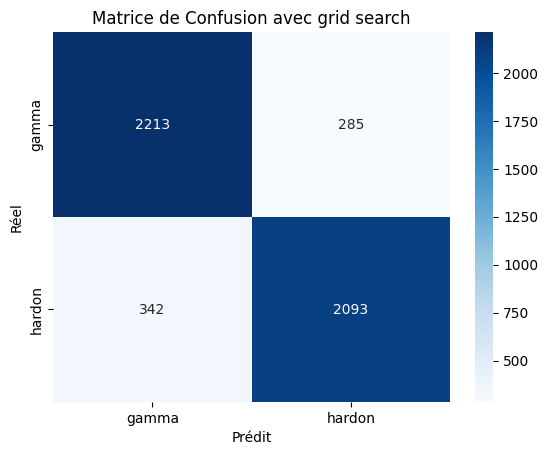

In [ ]:
# Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
# Afficher la matrice de confusion sous forme de heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["gamma", "hardon"], yticklabels=["gamma", "hardon"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de Confusion avec grid search")
plt.show()

Tableau ROC :
   Seuil  Taux Faux Positifs (FPR)  Taux Vrais Positifs (TPR)
0    inf                  0.000000                   0.000000
1    1.0                  0.114091                   0.859548
2    0.0                  1.000000                   1.000000


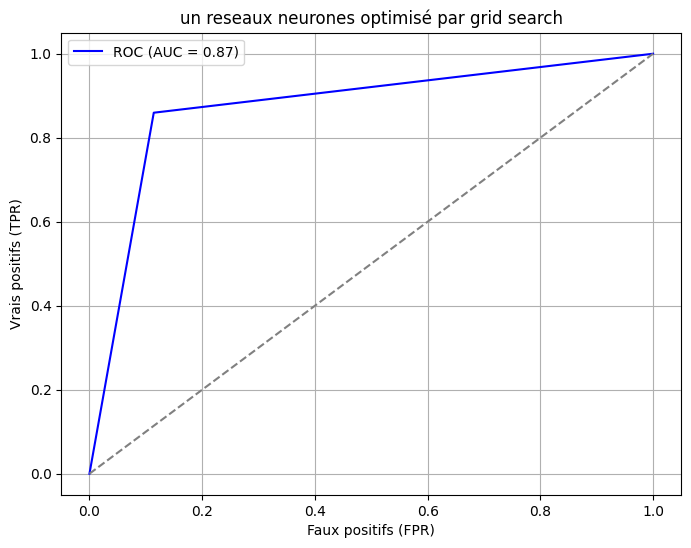

In [ ]:
# Obtenir les probabilités prédites pour la classe positive
y_scores = best_model.predict(X_test)

# Générer les points pour la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Créer le tableau ROC
roc_df = pd.DataFrame({
    'Seuil': thresholds,
    'Taux Faux Positifs (FPR)': fpr,
    'Taux Vrais Positifs (TPR)': tpr
})

print("Tableau ROC :")
print(roc_df.head(10))  # Affiche les 10 premières lignes

# Optionnel : tracer la courbe ROC
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("Faux positifs (FPR)")
plt.ylabel("Vrais positifs (TPR)")
plt.title("un reseaux neurones optimisé par grid search")
plt.legend()
plt.grid(True)
plt.show()

<h2>Comparaison des Performances des Algorithmes

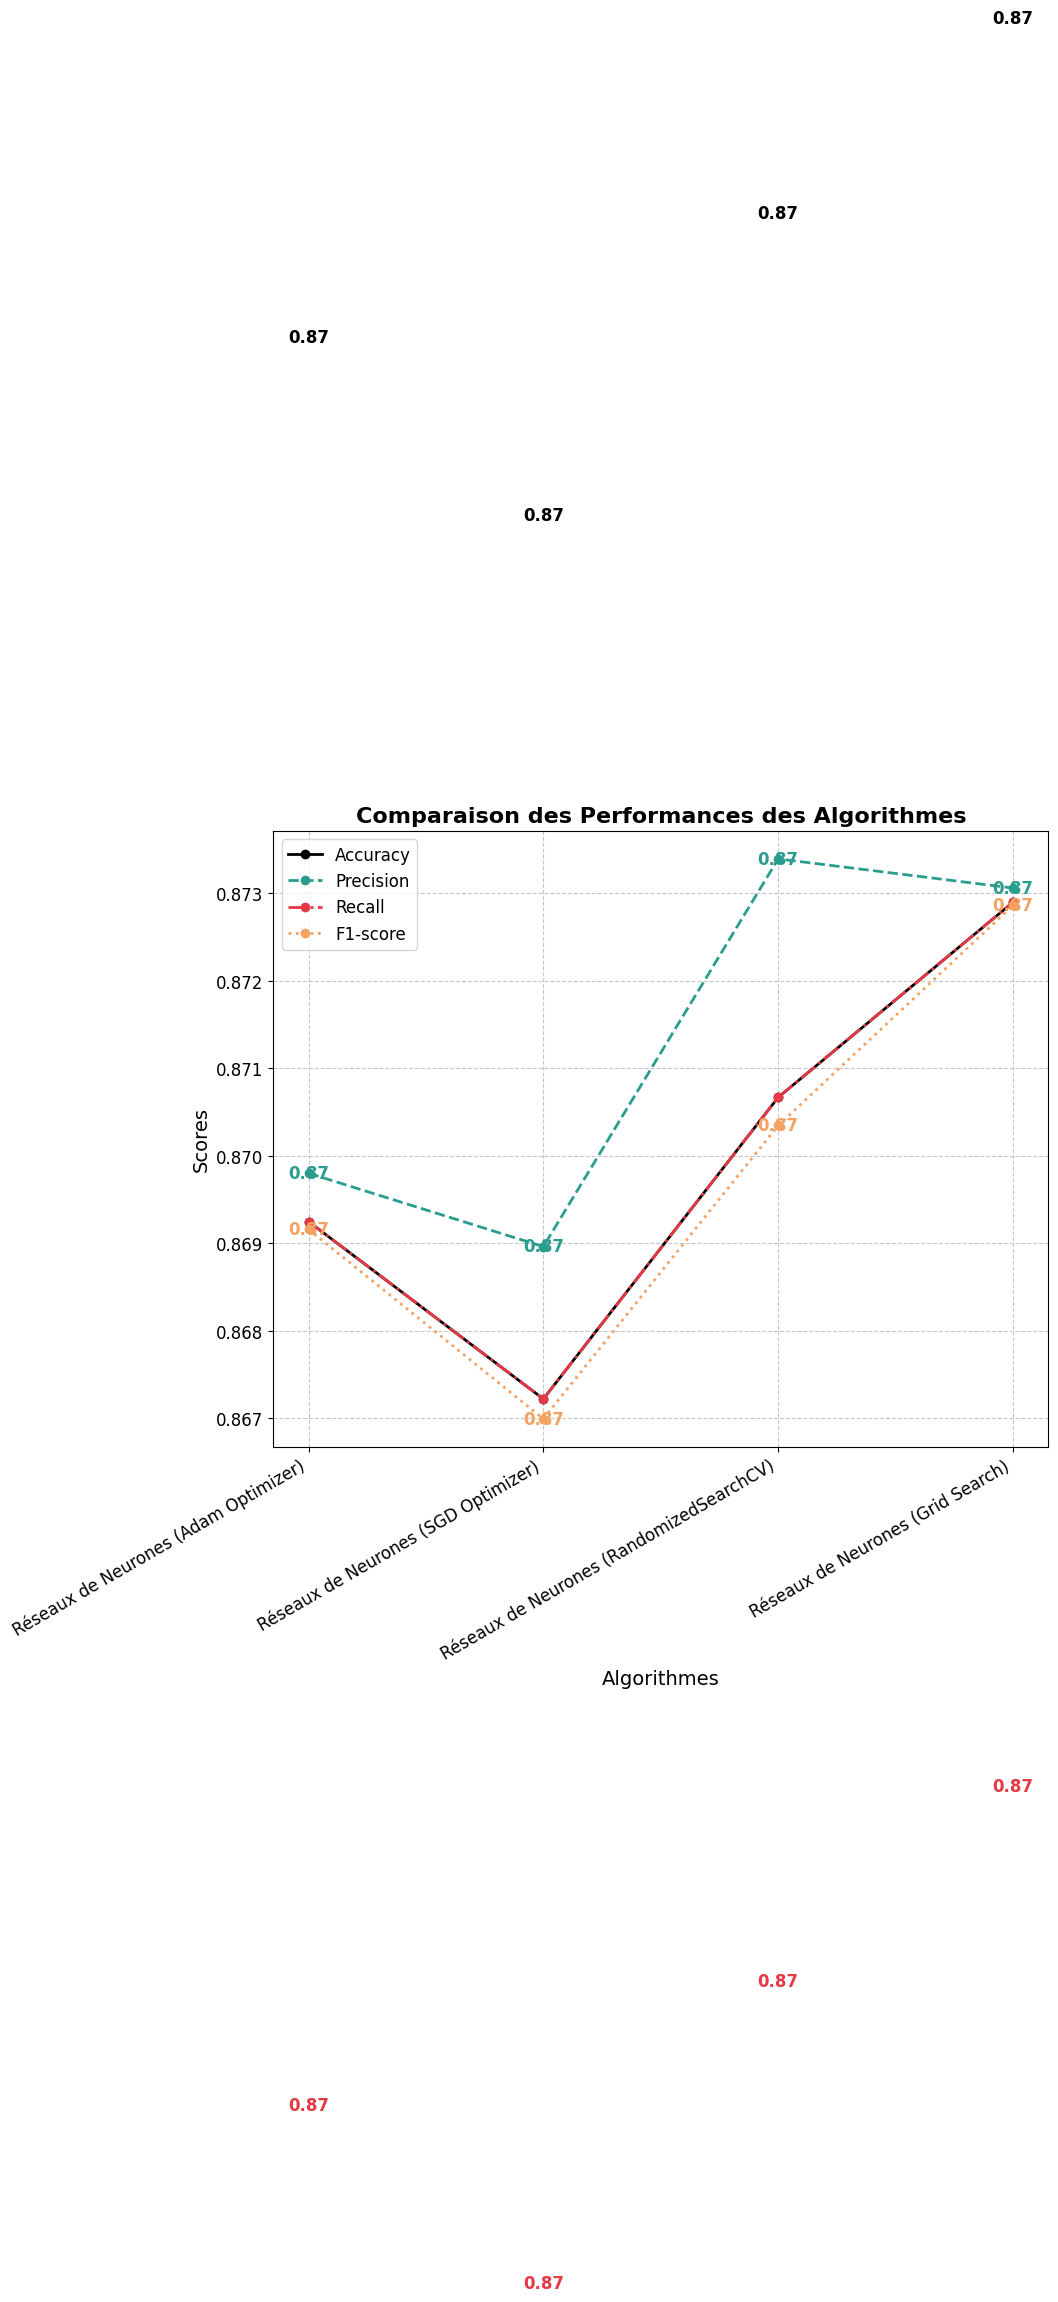

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple de valeurs de scores (Assurez-vous que ces valeurs existent avant l'exécution)
accuracy_scores = [accuracy_to, accuracy_SD, accuracy_Ra, accuracy_gh]
precision_scores = [precision_to, precision_SD, precision_Ra, precision_gh]
recall_scores = [recall_to, recall_SD, recall_Ra, recall_gh]
f1_scores = [f1_to, f1_SD, f1_Ra, f1_gh]

# Convertir en scalaires si ce sont des tableaux
accuracy_scores = [np.mean(np.asarray(score)) for score in accuracy_scores]
precision_scores = [np.mean(np.asarray(score)) for score in precision_scores]
recall_scores = [np.mean(np.asarray(score)) for score in recall_scores]
f1_scores = [np.mean(np.asarray(score)) for score in f1_scores]

# Noms des algorithmes
algorithm_names = [
    'Réseaux de Neurones (Adam Optimizer)',
    'Réseaux de Neurones (SGD Optimizer)',
    'Réseaux de Neurones (RandomizedSearchCV)',
    'Réseaux de Neurones (Grid Search)'
]

# 🎨 Couleurs et styles pour bien séparer les courbes
colors = ['#000000', '#2a9d8f', '#e63946', '#f4a261']  # Noir, Vert, Rouge, Orange
linestyles = ['-', '--', '-.', ':']  # Plein, Pointillé, Tirets, Pointillé fin
score_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
score_values = [accuracy_scores, precision_scores, recall_scores, f1_scores]

plt.figure(figsize=(10, 8))

# Tracer les courbes avec des annotations
for scores, label, color, style in zip(score_values, score_labels, colors, linestyles):
    plt.plot(algorithm_names, scores, marker='o', linestyle=style, label=label, color=color, linewidth=2)

    # Éviter la superposition des annotations
    for i, score in enumerate(scores):
        if label == 'Accuracy':
            offset, va_position = 0.01, 'bottom'
        elif label == 'Recall':
            offset, va_position = -0.01, 'top'
        else:
            offset, va_position = 0, 'center'

        plt.text(algorithm_names[i], score + offset, f'{score:.2f}',
                 ha='center', va=va_position, fontsize=12, fontweight='bold', color=color)

# Configuration du graphique
plt.xlabel('Algorithmes', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.title('Comparaison des Performances des Algorithmes', fontsize=16, fontweight='bold')
plt.xticks(rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)

# Sauvegarde et affichage
plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
Performance = pd.DataFrame ( index = algorithm_names )
Performance [ "Accuracy" ] = accuracy_scores
Performance [ "Precision" ] = precision_scores
Performance [ "Recall" ] = recall_scores
Performance [ "f1_score" ] = f1_scores

Performance

,Accuracy,Precision,Recall,f1_score
Réseaux de Neurones (Adam Optimizer),0.869248,0.869800,0.869248,0.869159
Réseaux de Neurones (SGD Optimizer),0.867221,0.868961,0.867221,0.866993
Réseaux de Neurones (RandomizedSearchCV),0.870667,0.873392,0.870667,0.870346
Réseaux de Neurones (Grid Search),0.872897,0.873059,0.872897,0.872861
